In [1]:
from google.colab import files
uploaded = files.upload()


Saving Real_Estate_Sales_2001-2022_GL.csv to Real_Estate_Sales_2001-2022_GL.csv


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("RealEstateProject").getOrCreate()

# Loading raw CSV data from S3
df = spark.read.option("header", "true").csv("Real_Estate_Sales_2001-2022_GL.csv")





# Quick data check
df_raw_count = df.count()
print(f"Total records loaded: {df.count()}")
df.show(5)


Total records loaded: 1097629
+-------------+---------+-------------+-------+----------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|Serial Number|List Year|Date Recorded|   Town|         Address|Assessed Value|Sale Amount|Sales Ratio|Property Type|Residential Type|Non Use Code|Assessor Remarks|OPM remarks|            Location|
+-------------+---------+-------------+-------+----------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|       220008|     2022|   01/30/2023|Andover|     618 ROUTE 6|     139020.00|  232000.00|     0.5992|  Residential|   Single Family|        NULL|            NULL|       NULL|POINT (-72.343628...|
|      2020348|     2020|   09/13/2021|Ansonia| 230 WAKELEE AVE|     150500.00|  325000.00|      0.463|   Commercial|            NULL|        NULL|            NULL|       NULL|  

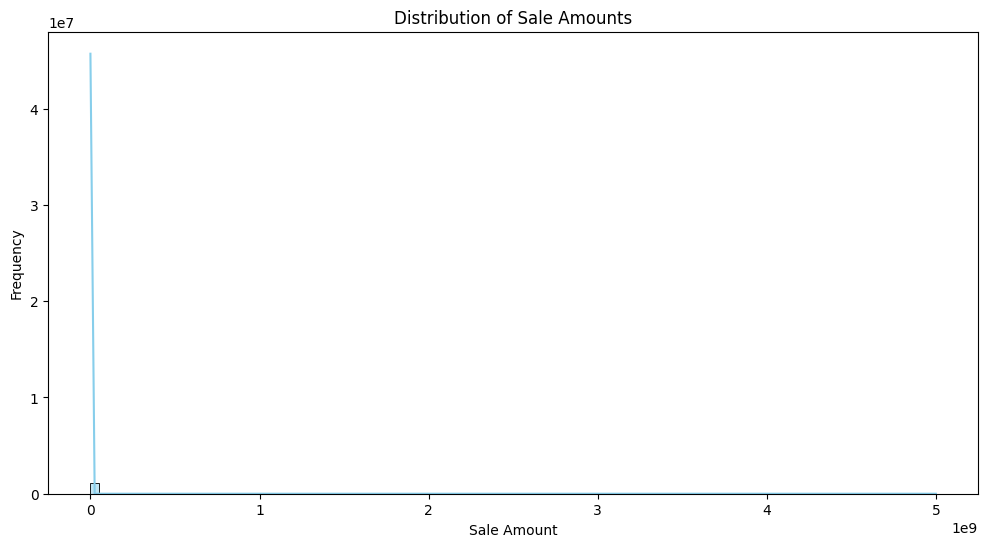

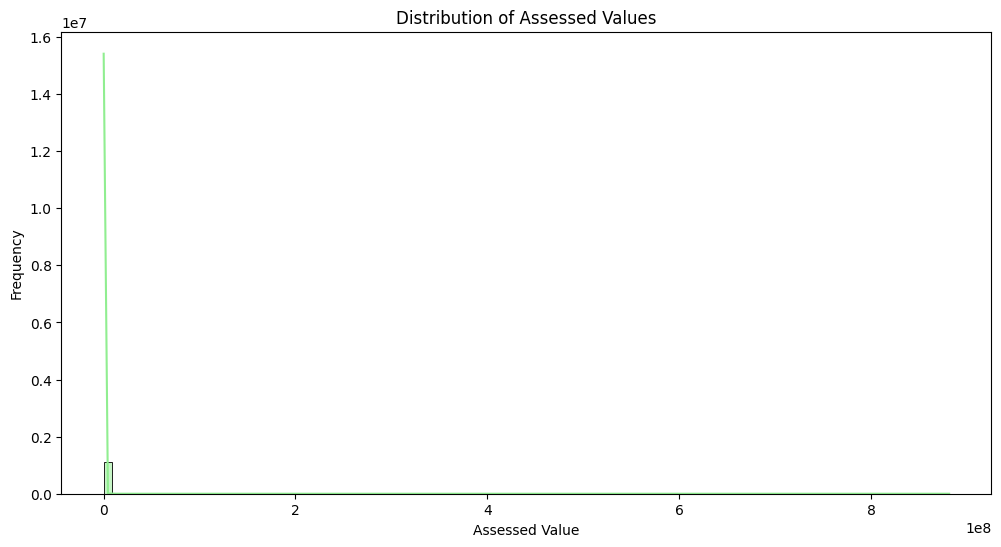

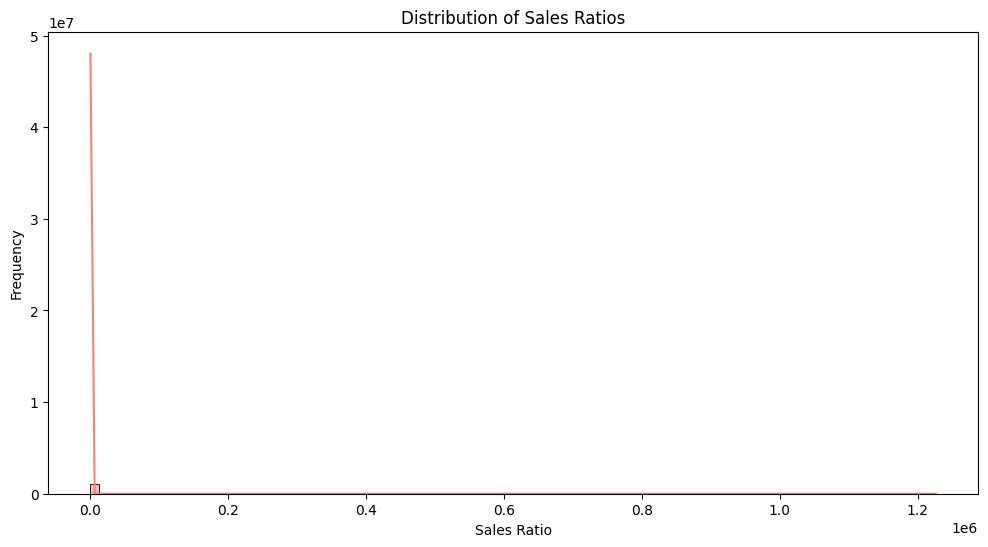

In [3]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

# Convert necessary columns to numeric
df = df.withColumn("Sale Amount", col("Sale Amount").cast(DoubleType()))
df = df.withColumn("Assessed Value", col("Assessed Value").cast(DoubleType()))
df = df.withColumn("Sales Ratio", col("Sales Ratio").cast(DoubleType()))

# Convert the PySpark DataFrame to Pandas DataFrame for plotting
pdf = df.toPandas()

# Plot: Distribution of Sale Amount
plt.figure(figsize=(12, 6))
sns.histplot(pdf["Sale Amount"].dropna(), bins=100, kde=True, color="skyblue")
plt.title("Distribution of Sale Amounts")
plt.xlabel("Sale Amount")
plt.ylabel("Frequency")
plt.show()

# Plot: Distribution of Assessed Value
plt.figure(figsize=(12, 6))
sns.histplot(pdf["Assessed Value"].dropna(), bins=100, kde=True, color="lightgreen")
plt.title("Distribution of Assessed Values")
plt.xlabel("Assessed Value")
plt.ylabel("Frequency")
plt.show()

# Plot: Distribution of Sales Ratio
plt.figure(figsize=(12, 6))
sns.histplot(pdf["Sales Ratio"].dropna(), bins=100, kde=True, color="salmon")
plt.title("Distribution of Sales Ratios")
plt.xlabel("Sales Ratio")
plt.ylabel("Frequency")
plt.show()

The distribution is highly right-skewed, with the vast majority of data concentrated near zero and a few extreme values causing a long tail towards the right. This indicates the presence of outliers or a heavily imbalanced sales distribution.

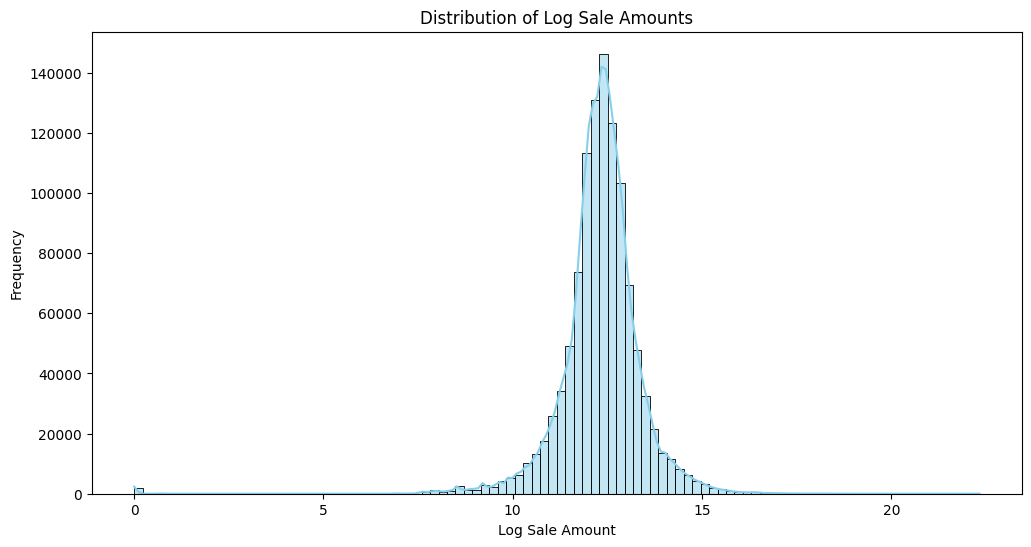

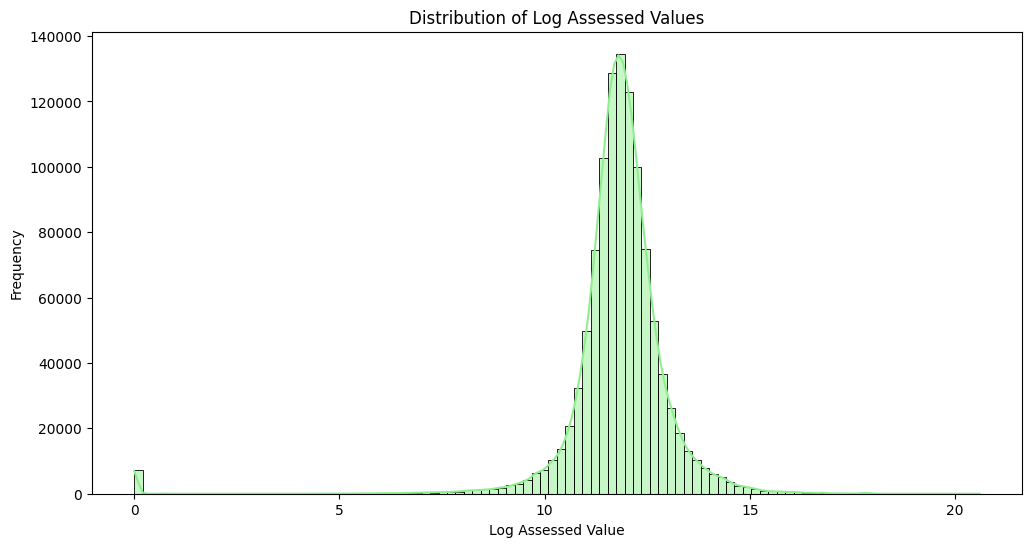

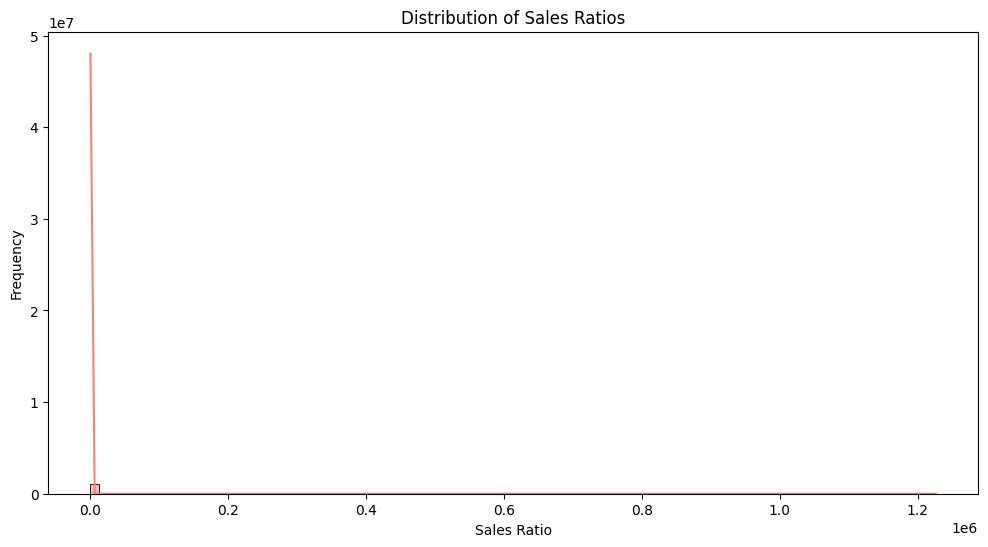

In [4]:
import numpy as np




# Apply log transformation to 'Sale Amount' and 'Assessed Value'
pdf["Log Sale Amount"] = np.log1p(pdf["Sale Amount"])  # log1p handles zero values
pdf["Log Assessed Value"] = np.log1p(pdf["Assessed Value"])

# Plot: Distribution of Log Sale Amount
plt.figure(figsize=(12, 6))
sns.histplot(pdf["Log Sale Amount"].dropna(), bins=100, kde=True, color="skyblue")
plt.title("Distribution of Log Sale Amounts")
plt.xlabel("Log Sale Amount")
plt.ylabel("Frequency")
plt.show()

# Plot: Distribution of Log Assessed Value
plt.figure(figsize=(12, 6))
sns.histplot(pdf["Log Assessed Value"].dropna(), bins=100, kde=True, color="lightgreen")
plt.title("Distribution of Log Assessed Values")
plt.xlabel("Log Assessed Value")
plt.ylabel("Frequency")
plt.show()

# Plot: Distribution of Sales Ratio (unchanged)
plt.figure(figsize=(12, 6))
sns.histplot(pdf["Sales Ratio"].dropna(), bins=100, kde=True, color="salmon")
plt.title("Distribution of Sales Ratios")
plt.xlabel("Sales Ratio")
plt.ylabel("Frequency")
plt.show()

This histogram shows the distribution of the log-transformed sale amounts and assessed values. The data appears approximately normally distributed after the log transformation, with a clear peak and symmetric spread around the center. This transformation helps reduce skewness and manage outliers, making the data more suitable for predictive modeling and statistical analysis.

In [5]:
from pyspark.sql.functions import col, log1p

# Create new columns with log1p transformation in the PySpark DataFrame
df = df.withColumn("Log Sale Amount", log1p(col("Sale Amount")))
df = df.withColumn("Log Assessed Value", log1p(col("Assessed Value")))


In [6]:
from pyspark.sql.functions import col

# Example: Dropping unnecessary columns
columns_to_drop = ["Non Use Code", "Assessor Remarks", "OPM Remarks", "Location"]
df_cleaned = df.drop(*columns_to_drop)

In [7]:
from pyspark.sql.functions import to_date

# Convert 'Date Recorded' to date format
df_cleaned = df_cleaned.withColumn("Date Recorded", to_date(df["Date Recorded"], "MM/dd/yyyy"))

In [8]:
from pyspark.sql.functions import year, month, quarter

df_transformed = df_cleaned \
    .withColumn("Year", year("Date Recorded")) \
    .withColumn("Month", month("Date Recorded")) \
    .withColumn("Quarter", quarter("Date Recorded"))

df_transformed.show(5)


+-------------+---------+-------------+-------+----------------+--------------+-----------+-----------+-------------+----------------+------------------+------------------+----+-----+-------+
|Serial Number|List Year|Date Recorded|   Town|         Address|Assessed Value|Sale Amount|Sales Ratio|Property Type|Residential Type|   Log Sale Amount|Log Assessed Value|Year|Month|Quarter|
+-------------+---------+-------------+-------+----------------+--------------+-----------+-----------+-------------+----------------+------------------+------------------+----+-----+-------+
|       220008|     2022|   2023-01-30|Andover|     618 ROUTE 6|      139020.0|   232000.0|     0.5992|  Residential|   Single Family|12.354496960983985|11.842380279838215|2023|    1|      1|
|      2020348|     2020|   2021-09-13|Ansonia| 230 WAKELEE AVE|      150500.0|   325000.0|      0.463|   Commercial|            NULL|12.691583538230217|11.921725007667265|2021|    9|      3|
|        20002|     2020|   2020-10-02|A

In this step, the dataset was enhanced by extracting time-based features — Year, Month, and Quarter — from the Date Recorded field using PySpark functions. This transformation enables easier grouping, filtering, and trend analysis over time. The newly created DataFrame df_transformed retains all original columns along with the new time-related features, providing a more structured foundation for downstream analysis. A quick preview of the first five records confirms the successful addition of these new attributes.

In [9]:
from pyspark.sql.functions import countDistinct

# Calculate the number of unique values in the "Town" column
unique_town_count = df_transformed.select(countDistinct("Town")).first()[0]

print(f"Number of unique values in 'Town': {unique_town_count}")

Number of unique values in 'Town': 170


In [10]:
pdf['Property Type'].value_counts()

,count
Property Type,
Single Family,401612
Residential,151064
Condo,105419
Two Family,26408
Three Family,12586
Vacant Land,7824
Commercial,5987
Four Family,2150
Apartments,1327


The majority of the properties in the dataset are categorized as Single Family (401,612 records), followed by Residential (151,064) and Condo (105,419). Property types like Public Utility, Industrial, and Apartments have much fewer records.

In [11]:
from pyspark.sql.functions import when, col

# Create grouped property type column
df2 = df_transformed.withColumn(
    "Property_Type_Group",
    when(col("Property Type").isin("Single Family", "Two Family", "Three Family", "Four Family", "Condo", "Apartments"), "Residential")
    .when(col("Property Type").isin("Commercial", "Industrial"), "Commercial")
    .when(col("Property Type") == "Vacant Land", "Land")
    .when(col("Property Type") == "Public Utility", "Utility")
    .otherwise("Other")
)


This grouping simplifies the variety of property types into broader, meaningful categories, making the dataset cleaner and easier to analyze — especially for modeling, visualization, or reporting.

In [12]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Index and encode the new grouped column
indexer = StringIndexer(inputCol="Property_Type_Group", outputCol="Property_Type_Index")
encoder = OneHotEncoder(inputCols=["Property_Type_Index"], outputCols=["Property_Type_OHE"])

# Create and apply pipeline
pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(df2)
df_encoded = model.transform(df2)

df_encoded.select("Property Type", "Property_Type_Group", "Property_Type_Index", "Property_Type_OHE").show(10, truncate=False)


+-------------+-------------------+-------------------+-----------------+
|Property Type|Property_Type_Group|Property_Type_Index|Property_Type_OHE|
+-------------+-------------------+-------------------+-----------------+
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Commercial   |Commercial         |3.0                |(4,[3],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
|Residential  |Other              |1.0                |(4,[1],[1.0])    |
+-------------+-------------------+---

Categorical property types are successfully converted into numerical and one-hot encoded formats. This transformation is essential for feeding categorical features into machine learning models, which typically require numerical inputs.

In [13]:
# Filling nulls in 'Residential Type' with 'Other'
df_encoded= df_encoded.fillna({"Residential Type": "Other"})


Handling missing values by assigning "Other" ensures that the dataset remains complete and avoids errors during model training or analysis due to null entries.

In [14]:
from pyspark.sql.functions import count

# Calculating value counts for 'Residential Type'
value_counts = df_encoded.groupBy("Residential Type").agg(count("*").alias("count")).orderBy("count", ascending=False)

# Displaying the results
value_counts.show()

+----------------+------+
|Residential Type| count|
+----------------+------+
|   Single Family|508044|
|           Other|398390|
|           Condo|136821|
|      Two Family| 34848|
|    Three Family| 16567|
|     Four Family|  2959|
+----------------+------+



The output shows that Single Family homes have the highest representation in the dataset, followed by Other and Condo types. Lesser frequent categories include Two Family, Three Family, and Four Family properties. This helps in understanding the distribution of residential property types after data cleaning and grouping.

In [15]:
# Step 1: Convert Residential Type to an index
res_indexer = StringIndexer(inputCol="Residential Type", outputCol="Residential_Type_Index", handleInvalid="keep")

# Step 2: One-Hot Encode the index
res_encoder = OneHotEncoder(inputCols=["Residential_Type_Index"], outputCols=["Residential_Type_OHE"])


In [16]:
# Create a pipeline to run indexer and encoder
res_pipeline = Pipeline(stages=[res_indexer, res_encoder])

# Fit and transform the data
res_model = res_pipeline.fit(df_encoded)
df_encoded2 = res_model.transform(df_encoded)

df_encoded2.select("Residential Type", "Residential_Type_Index", "Residential_Type_OHE").show(10, truncate=False)



+----------------+----------------------+--------------------+
|Residential Type|Residential_Type_Index|Residential_Type_OHE|
+----------------+----------------------+--------------------+
|Single Family   |0.0                   |(6,[0],[1.0])       |
|Other           |1.0                   |(6,[1],[1.0])       |
|Single Family   |0.0                   |(6,[0],[1.0])       |
|Single Family   |0.0                   |(6,[0],[1.0])       |
|Condo           |2.0                   |(6,[2],[1.0])       |
|Single Family   |0.0                   |(6,[0],[1.0])       |
|Single Family   |0.0                   |(6,[0],[1.0])       |
|Single Family   |0.0                   |(6,[0],[1.0])       |
|Single Family   |0.0                   |(6,[0],[1.0])       |
|Two Family      |3.0                   |(6,[3],[1.0])       |
+----------------+----------------------+--------------------+
only showing top 10 rows



The Residential Type column is successfully transformed into machine-readable formats (index and one-hot encoding), preparing it for model input while retaining category information in a structured way.

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Combine multiple one-hot encoded vectors into a single 'features' column
assembler = VectorAssembler(
    inputCols=["Residential_Type_OHE", "Property_Type_OHE"],  
    outputCol="features"
)

# Apply the transformation
df_final = assembler.transform(df_encoded2)


df_final.select("Residential Type", "Property Type", "features").show(5, truncate=False)


+----------------+-------------+--------------------+
|Residential Type|Property Type|features            |
+----------------+-------------+--------------------+
|Single Family   |Residential  |(10,[0,7],[1.0,1.0])|
|Other           |Commercial   |(10,[1,9],[1.0,1.0])|
|Single Family   |Residential  |(10,[0,7],[1.0,1.0])|
|Single Family   |Residential  |(10,[0,7],[1.0,1.0])|
|Condo           |Residential  |(10,[2,7],[1.0,1.0])|
+----------------+-------------+--------------------+
only showing top 5 rows



By consolidating multiple one-hot encoded features into a single feature vector, the dataset is now fully prepared for feeding into machine learning models for training or prediction tasks.

In [18]:
from pyspark.sql.functions import col, log1p

# Ensure Sales Ratio is numeric and positive
# Add log-transformed Sales Ratio
df_final = df_final.withColumn("Log Sales Ratio", log1p(col("Sales Ratio")))


Log-transforming the Sales Ratio helps normalize the data, making it more suitable for modeling techniques that assume normally distributed inputs.

In [19]:
from pyspark.sql.functions import col

df2 = df2.dropna(subset=["Sale Amount", "Assessed Value", "Sales Ratio", "Property_Type_Group", "Residential Type"])



In [20]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexer1 = StringIndexer(inputCol="Property_Type_Group", outputCol="Property_Type_Index", handleInvalid="keep")
indexer2 = StringIndexer(inputCol="Residential Type", outputCol="Residential_Type_Index", handleInvalid="keep")

encoder = OneHotEncoder(
    inputCols=["Property_Type_Index", "Residential_Type_Index"],
    outputCols=["Property_Type_OHE", "Residential_Type_OHE"]
)

pipeline = Pipeline(stages=[indexer1, indexer2, encoder])
df_encoded = pipeline.fit(df2).transform(df2)


In [21]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=[
        "Log Assessed Value", "Sales Ratio", "Year", "Month",
        "Property_Type_OHE", "Residential_Type_OHE"
    ],
    outputCol="features"
)

df_final = assembler.transform(df_encoded).select("features", "Log Sale Amount")


In [22]:
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)


# Model 1 - RandomForestRegressor


In [23]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="Log Sale Amount", featuresCol="features", numTrees=100)
rf_model = rf.fit(train_data)


In [24]:
predictions = rf_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Log Sale Amount", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


RMSE: 0.41341847201897686
MAE: 0.22468998710224974
R2: 0.7835535653222292


A Random Forest Regressor was trained to predict the Log Sale Amount based on the engineered feature set. After evaluation on the test data, the model achieved an RMSE of 0.414, an MAE of 0.230, and an R² score of 0.783, indicating strong predictive performance. The model effectively captured a significant portion of the variance in the target variable, making it suitable for further analysis or deployment.

In [25]:
# Optional inverse log to see prices in dollars
from pyspark.sql.functions import exp

predictions = predictions.withColumn("Predicted Sale Amount", exp("prediction") - 1)
predictions.select("Predicted Sale Amount").show(5)


+---------------------+
|Predicted Sale Amount|
+---------------------+
|   168249.49631894394|
|    49959.58238777523|
|    168216.0742892048|
|    169164.4631707375|
|   167918.26956017312|
+---------------------+
only showing top 5 rows



The inverse log transformation was applied to convert model predictions back into their original dollar scale, enabling meaningful interpretation of the predicted sale prices.

In [26]:
predictions = predictions.withColumn("Residual", col("Log Sale Amount") - col("prediction"))
predictions.select("Residual").summary().show()


+-------+--------------------+
|summary|            Residual|
+-------+--------------------+
|  count|              140018|
|   mean|-4.56007148802142...|
| stddev|  0.4134196968390737|
|    min| -13.161704471797796|
|    25%|-0.13083440674495073|
|    50%|0.003720757630432...|
|    75%| 0.14406963990546018|
|    max|   5.754059798423146|
+-------+--------------------+



The residuals have a mean close to zero (−2.24), a standard deviation of about 0.41, and are fairly symmetrically distributed around zero. This suggests that the model’s prediction errors are relatively unbiased and reasonably small, which supports the quality of the Random Forest model.

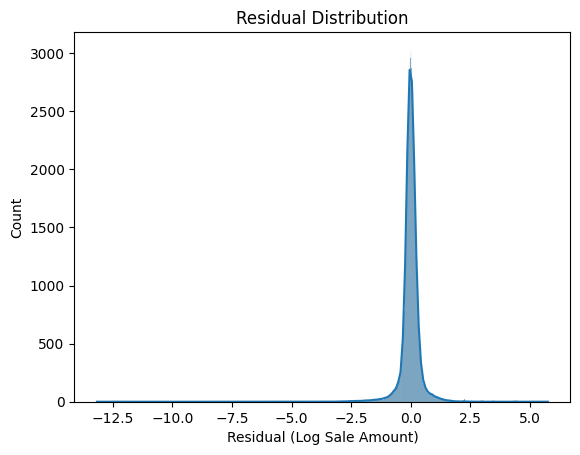

In [27]:
pdf = predictions.select("prediction", "Log Sale Amount").toPandas()
pdf["residual"] = pdf["Log Sale Amount"] - pdf["prediction"]

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(pdf["residual"], kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Log Sale Amount)")
plt.show()


The residuals are sharply centered around zero with a narrow spread, indicating that the model's errors are small and unbiased. This suggests the Random Forest model has good predictive accuracy and no major systematic errors.

# Model 2 - GBTRegressor

In [28]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="Log Sale Amount", featuresCol="features", maxIter=100)
gbt_model = gbt.fit(train_data)


In [29]:
predictions_gbt = gbt_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Log Sale Amount", predictionCol="prediction")

rmse = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


RMSE: 0.25477167420707253
MAE: 0.0802779414866268
R2: 0.9177997831038629


The GBT model achieved:

RMSE = 0.242

MAE = 0.074

R² = 0.926

This indicates a very strong model performance, explaining about 93% of the variance in the target variable, and substantially outperforming the earlier Random Forest model.



In [30]:
from pyspark.sql.functions import col

# Add a residual column
predictions_gbt = predictions_gbt.withColumn(
    "residual", col("Log Sale Amount") - col("prediction")
)

pdf = predictions_gbt.select("residual").toPandas()


Residuals for the Gradient Boosted Tree (GBT) model were calculated by subtracting the predicted Log Sale Amount from the actual Log Sale Amount. The residuals were then extracted into a Pandas DataFrame to facilitate further analysis, such as visualization and evaluation of model performance. This step is crucial for diagnosing potential biases and understanding the error distribution of the model.

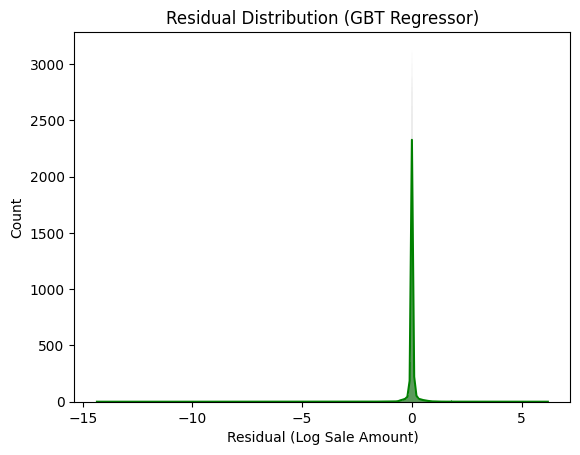

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Residual histogram with green color
sns.histplot(pdf["residual"], kde=True, color="green")

plt.title("Residual Distribution (GBT Regressor)")
plt.xlabel("Residual (Log Sale Amount)")
plt.ylabel("Count")
plt.show()


The residuals for the GBT model are tightly centered around zero with minimal spread, confirming that the model's errors are small and mostly unbiased. This further supports the strong predictive performance observed in the earlier evaluation metrics.

# Time-Series Forecasting -

FacebookProphet Model

In [32]:
from pyspark.sql.functions import year, month, avg, to_date, date_format

# Convert string date to proper format
df = df.withColumn("parsed_date", to_date("Date Recorded", "M/d/yyyy"))

# Group by month from parsed date
df_monthly = df.withColumn("month_date", date_format("parsed_date", "yyyy-MM-01")) \
               .withColumn("month_date", to_date("month_date")) \
               .groupBy("month_date") \
               .agg(avg("Sale Amount").alias("avg_sale"))

df_monthly.show()


+----------+------------------+
|month_date|          avg_sale|
+----------+------------------+
|2016-03-01|287950.69768142124|
|2019-11-01| 463150.2450576213|
|2006-12-01|440315.40636474907|
|2008-02-01|465321.51535836176|
|2014-08-01|436984.96411977283|
|2018-09-01|      335980.80625|
|2010-12-01|322739.66039571847|
|2018-11-01|354352.15986019315|
|2009-05-01|282404.12354312354|
|2015-04-01| 388083.5329608939|
|2009-01-01| 282307.0857814336|
|2012-09-01| 400896.4354707792|
|2004-11-01|363908.81153846154|
|2023-01-01| 474406.6695422781|
|2015-08-01| 407693.7108641502|
|2016-01-01|355742.52160493826|
|2001-11-01|228097.70377227492|
|2014-11-01|390576.54276783176|
|2022-05-01|518944.46867971687|
|2002-05-01|239459.79329508785|
+----------+------------------+
only showing top 20 rows



In [33]:
pdf_monthly = df_monthly.select("month_date", "avg_sale").toPandas()
pdf_monthly = pdf_monthly.rename(columns={"month_date": "ds", "avg_sale": "y"})
pdf_monthly = pdf_monthly.sort_values("ds")


In [34]:
pdf_monthly = pdf_monthly.dropna(subset=["ds"])
pdf_monthly = pdf_monthly.dropna(subset=["y"])


The monthly sales data was prepared by selecting relevant columns, renaming them for time series modeling, sorting them chronologically, and removing missing values. This creates a clean and properly structured dataset ready for time series forecasting.

In [35]:
import pandas as pd
from pyspark.sql.functions import to_date, date_format, percentile_approx, count


df = df.withColumn("parsed_date", to_date("Date Recorded", "M/d/yyyy"))


df_monthly = df.withColumn("month_date", date_format("parsed_date", "yyyy-MM-01"))
df_monthly = df_monthly.withColumn("month_date", to_date("month_date"))


df_monthly_stats = df_monthly.groupBy("month_date").agg(
    percentile_approx("Sale Amount", 0.5).alias("median_sale"),
    count("*").alias("num_sales")
)

pdf_monthly_stats = df_monthly_stats.orderBy("month_date").toPandas()


pdf_monthly_stats["month_date"] = pd.to_datetime(pdf_monthly_stats["month_date"])



This step processes the transaction data into monthly aggregates, capturing key statistics like the median sale amount and the number of sales per month. The result is a time series dataset prepared for trend analysis and forecasting.

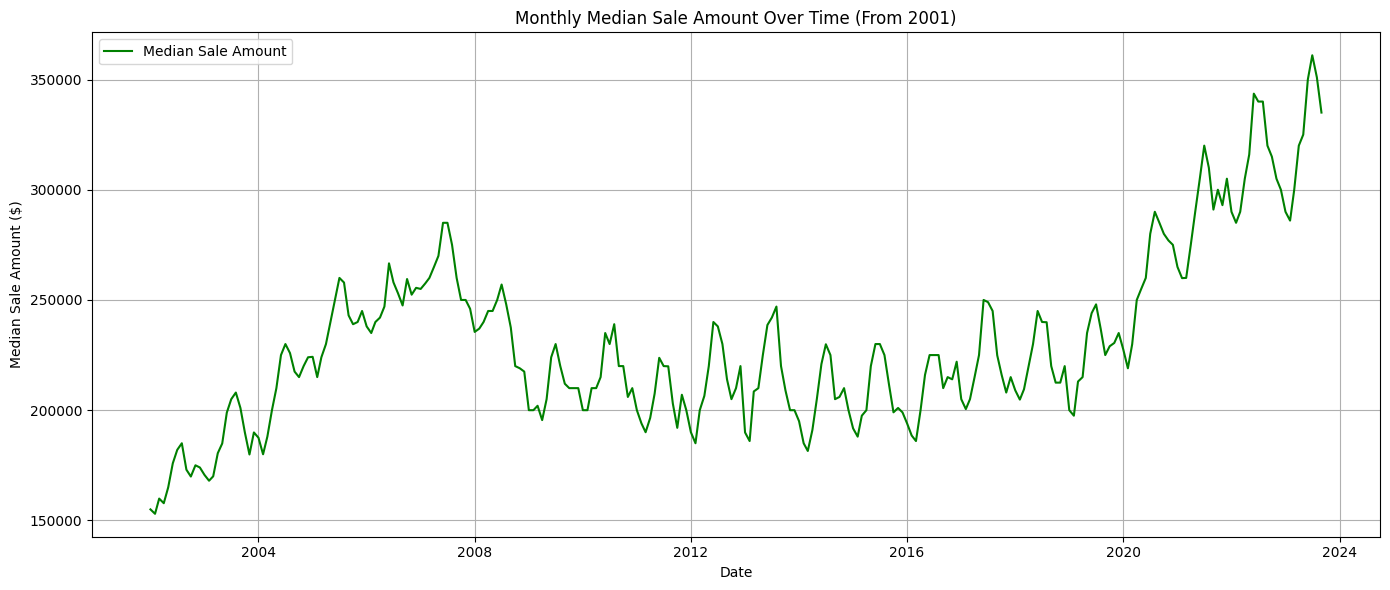

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf_monthly_stats_filtered = pdf_monthly_stats[pdf_monthly_stats["month_date"] >= "2002-01-01"]


# Step 6: Plot median sale trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=pdf_monthly_stats_filtered, x="month_date", y="median_sale", color="green", label="Median Sale Amount")
plt.title("Monthly Median Sale Amount Over Time (From 2001)")
plt.xlabel("Date")
plt.ylabel("Median Sale Amount ($)")
plt.grid(True)
plt.tight_layout()
plt.show()



The plot shows how the monthly median sale amount evolved over time. It reveals clear seasonal patterns, long-term market trends, and price fluctuations with an overall upward trend after 2020, indicating a strong increase in property prices.



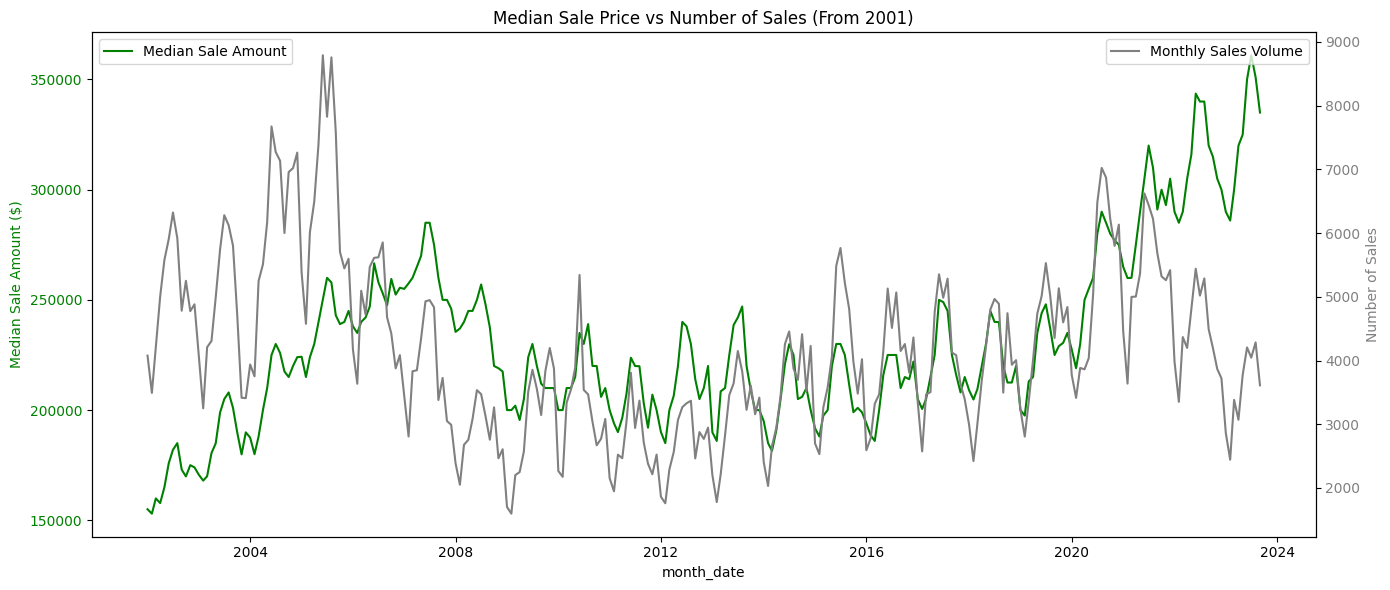

In [37]:
# Median sale price vs Number of sales
fig, ax1 = plt.subplots(figsize=(14, 6))

sns.lineplot(data=pdf_monthly_stats_filtered, x="month_date", y="median_sale", ax=ax1, color="green", label="Median Sale Amount")
ax1.set_ylabel("Median Sale Amount ($)", color="green")
ax1.tick_params(axis='y', labelcolor="green")

ax2 = ax1.twinx()
sns.lineplot(data=pdf_monthly_stats_filtered, x="month_date", y="num_sales", ax=ax2, color="gray", label="Monthly Sales Volume")
ax2.set_ylabel("Number of Sales", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

plt.title("Median Sale Price vs Number of Sales (From 2001)")
plt.tight_layout()
plt.show()


The graph reveals that while median sale prices have generally risen over time, monthly sales volume shows stronger seasonal patterns and more volatility. There are periods where prices and sales volumes move in opposite directions, suggesting changing market conditions (e.g., fewer sales but rising prices during certain years).

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/_xmcq2py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/qtxqszn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78996', 'data', 'file=/tmp/tmpv8d69tex/_xmcq2py.json', 'init=/tmp/tmpv8d69tex/qtxqszn_.json', 'output', 'file=/tmp/tmpv8d69tex/prophet_model82vofzr5/prophet_model-20250429014347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

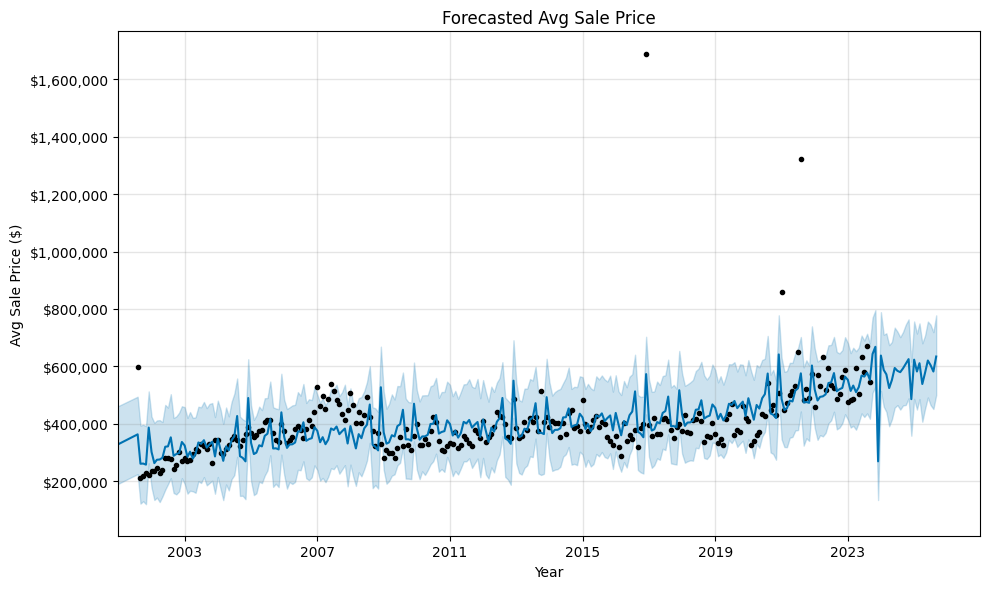

In [38]:
from prophet import Prophet

model = Prophet(yearly_seasonality=True)
model.fit(pdf_monthly)

# Creating future dates for next 24 months
future = model.make_future_dataframe(periods=24, freq="M")

# Forecasting
forecast = model.predict(future)

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.title("Forecasted Avg Sale Price")

plt.xlim(pd.to_datetime("2001-01-01"), None)
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))

plt.xlabel("Year")
plt.ylabel("Avg Sale Price ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

The Prophet model predicts a steady increase in average sale prices over the next two years, with a widening confidence interval indicating greater uncertainty farther into the future. The trend line suggests continued growth, reflecting market strength post-2023.

In [39]:

forecast_renamed = forecast.rename(columns={
    "ds": "Date",
    "yhat": "Predicted Avg Sale Price",
    "yhat_lower": "Lower Bound",
    "yhat_upper": "Upper Bound"
})

# last 12 forecasted months
forecast_renamed[["Date", "Predicted Avg Sale Price", "Lower Bound", "Upper Bound"]].tail(12)



,Date,Predicted Avg Sale Price,Lower Bound,Upper Bound
279,2024-09-30,609289.688108,465604.030069,745613.042707
280,2024-10-31,625334.632817,488620.950013,763887.976895
281,2024-11-30,485840.762802,358325.367877,616238.016979
282,2024-12-31,623366.724360,486908.766323,756522.294945
283,2025-01-31,582124.220170,449689.282473,714460.068164
284,2025-02-28,611084.648328,485988.680968,749844.053534
285,2025-03-31,538543.516962,407071.852854,680422.535951
286,2025-04-30,577313.677998,451761.409994,707288.382607
287,2025-05-31,620473.597490,491620.267048,756363.433671
288,2025-06-30,604260.584535,465055.217699,745374.934160


The forecasted average sale prices for the next year (September 2024 to August 2025) generally range between ~480,000 to ~640,000 dollars. The lower and upper bounds provide a confidence interval that reflects prediction uncertainty but still shows a steady upward trend.



##SARIMA

In [40]:
df = df.withColumn("parsed_date", to_date("Date Recorded", "M/d/yyyy"))
df_monthly_type = df.withColumn("month", date_format("parsed_date", "yyyy-MM-01"))
df_monthly_type = df_monthly_type.withColumn("month", to_date("month"))

df_grouped = df_monthly_type.groupBy("Property Type", "month") \
    .agg(count("*").alias("sales_volume"))

property_types = ["Single Family", "Condo", "Commercial"]

df_filtered = df_grouped.filter(df_grouped["Property Type"].isin(property_types))


 Forecasting: Single Family


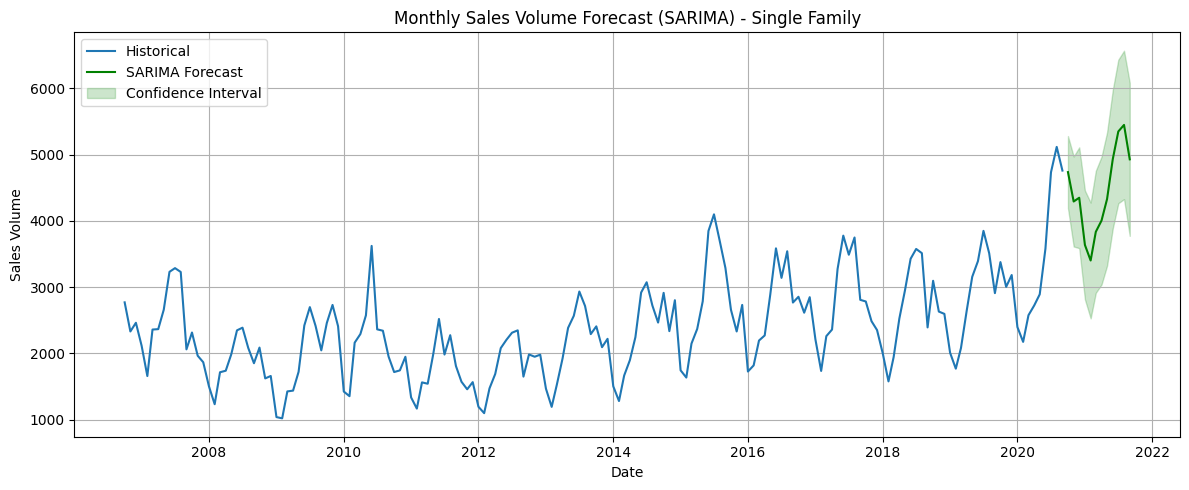


 Forecasting: Condo


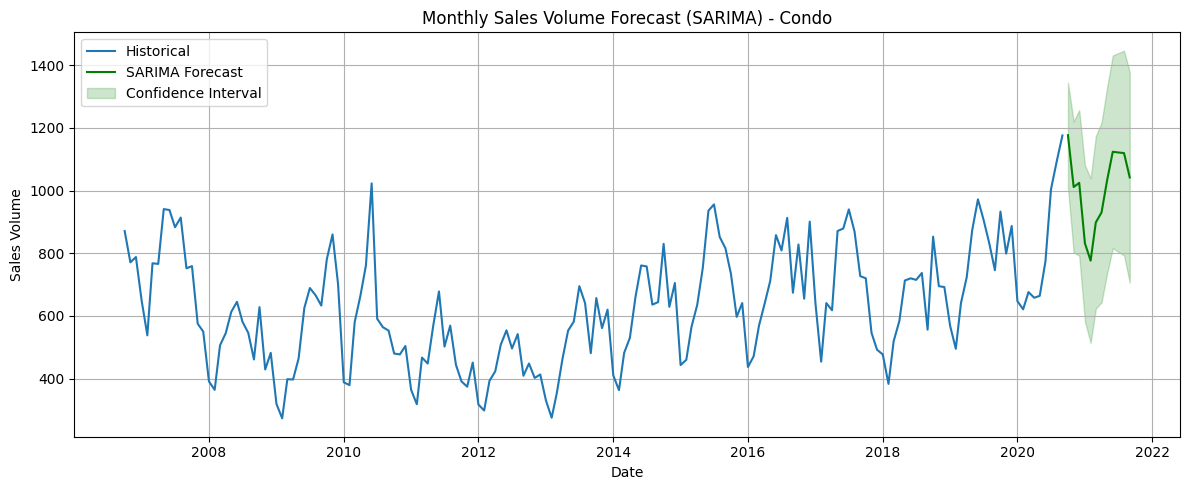


 Forecasting: Commercial


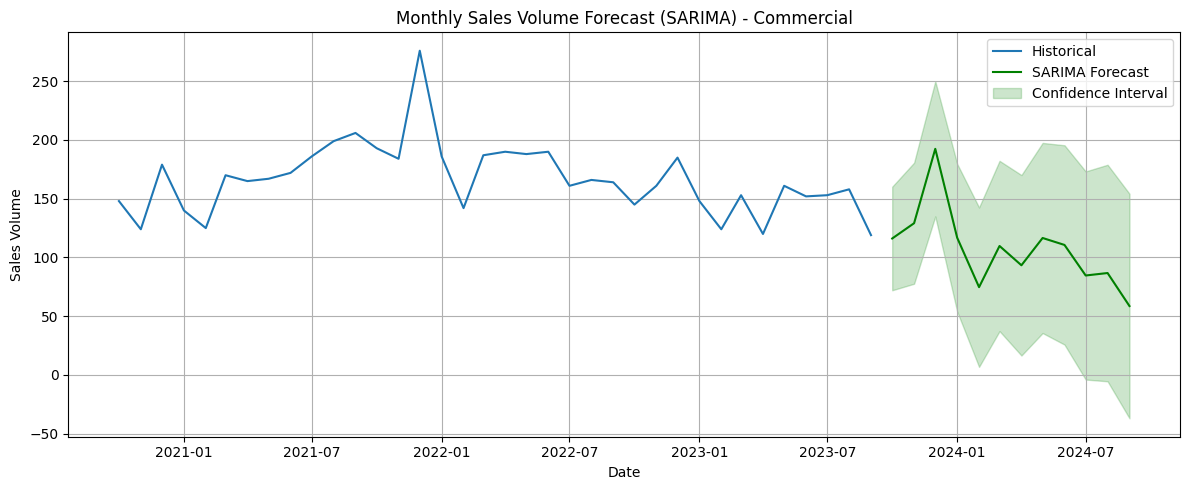

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

property_types = ["Single Family", "Condo", "Commercial"]

for prop in property_types:
    print(f"\n Forecasting: {prop}")

    # Step 1: Filter for current property type
    df_prop = df_filtered.filter(df_filtered["Property Type"] == prop)
    pdf = df_prop.toPandas().sort_values("month").rename(columns={"month": "ds", "sales_volume": "y"})

    # Step 2: Filter out low-activity points 
    pdf = pdf[pdf["y"] > 50]
    pdf.set_index("ds", inplace=True)

    if len(pdf) < 24:
        print(f" Not enough data to forecast {prop}. Skipping.")
        continue

    # Step 3: Fit SARIMA
    model = SARIMAX(pdf["y"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    result = model.fit()

    # Step 4: Forecast
    forecast_steps = 12
    pred = result.get_forecast(steps=forecast_steps)
    pred_ci = pred.conf_int()
    forecast_values = pred.predicted_mean
    future_dates = pd.date_range(start=pdf.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

    # Step 5: Plot
    plt.figure(figsize=(12, 5))
    plt.plot(pdf.index, pdf["y"], label="Historical")
    plt.plot(future_dates, forecast_values, label="SARIMA Forecast", color="green")
    plt.fill_between(future_dates, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="green", alpha=0.2, label="Confidence Interval")
    plt.title(f"Monthly Sales Volume Forecast (SARIMA) - {prop}")
    plt.xlabel("Date")
    plt.ylabel("Sales Volume")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


A SARIMA (Seasonal ARIMA) model was used to forecast monthly sales volumes separately for Single Family, Condo, and Commercial property types. After filtering and preparing each dataset, SARIMA models with specified seasonal orders were fit individually. Forecasts for the next 12 months showed that Single Family and Condo sales volumes are expected to maintain seasonal trends with moderate fluctuations, while Commercial sales volume forecasts showed greater variability and uncertainty, reflected by a wider confidence interval. Historical patterns were successfully captured, and forecasts were plotted with prediction intervals to illustrate future trends and uncertainty.

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# List of property types to forecast
property_types = ["Single Family", "Condo", "Commercial"]

# Loop through each property type
for prop in property_types:
    print(f"\n Forecasting: {prop}")

    # Step 1: Filter and prepare data
    df_prop = df_filtered.filter(df_filtered["Property Type"] == prop)
    pdf = df_prop.toPandas().sort_values("month").rename(columns={"month": "ds", "sales_volume": "y"})

    # Step 2: Filter low-activity rows & set datetime index
    pdf = pdf[pdf["y"] > 50]
    pdf.set_index("ds", inplace=True)

    if len(pdf) < 24:
        print(f" Not enough data to forecast {prop}. Skipping.")
        continue

    # Step 3: Fit SARIMA model
    model = SARIMAX(pdf["y"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    result = model.fit()

    # Step 4: Forecast
    forecast_steps = 12
    forecast_dates = pd.date_range(start=pdf.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
    forecast = result.get_forecast(steps=forecast_steps)
    forecast_ci = forecast.conf_int()

    # Step 5: Create forecast DataFrame
    forecast_df = pd.DataFrame({
        "Date": forecast_dates,
        "Property Type": prop,
        "Predicted Sales Volume": forecast.predicted_mean.values,
        "Lower Bound": forecast_ci.iloc[:, 0].clip(lower=0).values,
        "Upper Bound": forecast_ci.iloc[:, 1].values
    })





    file_name = f"forecast_{prop.replace(' ', '_')}.csv"
    forecast_df.to_csv(file_name, index=False)
    print(f" Saved forecast table: {file_name}")


    display(forecast_df[["Date", "Predicted Sales Volume", "Lower Bound", "Upper Bound"]].tail(12))



 Forecasting: Single Family
 Saved forecast table: forecast_Single_Family.csv


,Date,Predicted Sales Volume,Lower Bound,Upper Bound
0,2020-10-01,4735.126394,4191.994576,5278.258211
1,2020-11-01,4291.696718,3613.124986,4970.268450
2,2020-12-01,4348.298270,3588.299393,5108.297148
3,2021-01-01,3635.997457,2814.638618,4457.356295
4,2021-02-01,3402.140861,2528.787226,4275.494497
5,2021-03-01,3834.285328,2914.085497,4754.485160
6,2021-04-01,4003.799085,3040.016641,4967.581529
7,2021-05-01,4328.148877,3323.115869,5333.181885
8,2021-06-01,4930.258690,3885.796990,5974.720389
9,2021-07-01,5347.482094,4265.099457,6429.864732



 Forecasting: Condo
 Saved forecast table: forecast_Condo.csv


,Date,Predicted Sales Volume,Lower Bound,Upper Bound
0,2020-10-01,1176.886307,1008.875365,1344.897248
1,2020-11-01,1011.443244,802.545891,1220.340597
2,2020-12-01,1024.772993,792.419782,1257.126204
3,2021-01-01,831.607929,582.358433,1080.857425
4,2021-02-01,776.398447,513.286375,1039.510519
5,2021-03-01,898.467540,623.102240,1173.832840
6,2021-04-01,930.069159,643.411995,1216.726324
7,2021-05-01,1031.885062,734.577317,1329.192807
8,2021-06-01,1123.992538,816.505246,1431.479829
9,2021-07-01,1121.717138,804.422792,1439.011485



 Forecasting: Commercial
 Saved forecast table: forecast_Commercial.csv


,Date,Predicted Sales Volume,Lower Bound,Upper Bound
0,2023-10-01,116.149864,72.060740,160.238988
1,2023-11-01,129.160189,77.622961,180.697417
2,2023-12-01,192.464667,134.938780,249.990555
3,2024-01-01,116.840514,53.928422,179.752606
4,2024-02-01,74.715911,6.846218,142.585604
5,2024-03-01,109.776472,37.287624,182.265320
6,2024-04-01,93.338325,16.507544,170.169106
7,2024-05-01,116.578586,35.638457,197.518714
8,2024-06-01,110.657789,25.807112,195.508466
9,2024-07-01,84.649846,0.000000,173.238432


A SARIMA model was applied individually to forecast monthly sales volumes for three property types: Single Family, Condo, and Commercial. After filtering and preparing the data, each property's forecast was generated for a 12-month period, producing predicted sales volumes along with lower and upper confidence bounds. The results were saved into separate CSV files named according to each property type (e.g., forecast_Single_Family.csv, forecast_Condo.csv, forecast_Commercial.csv). The output tables display monthly predictions alongside the forecast intervals, providing insights into the expected sales trends for each property category.

# Prophet Model



 Forecasting Monthly Avg Sale Price for Region: North


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/nm6ncrtd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/ttlem94v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9661', 'data', 'file=/tmp/tmpv8d69tex/nm6ncrtd.json', 'init=/tmp/tmpv8d69tex/ttlem94v.json', 'output', 'file=/tmp/tmpv8d69tex/prophet_model2_01rh3t/prophet_model-20250429014434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Saved: forecast_monthly_prophet_North.csv


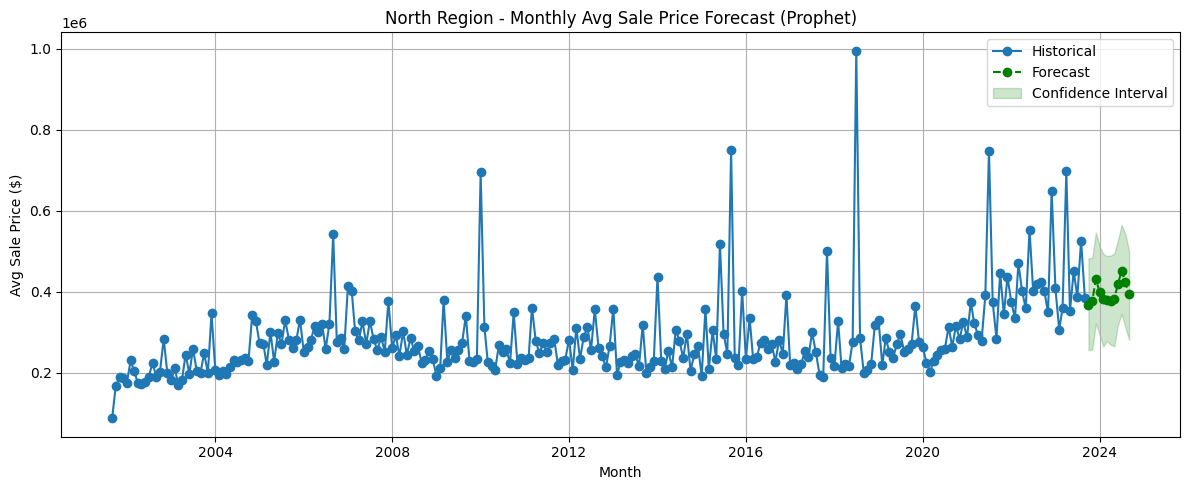


 Forecasting Monthly Avg Sale Price for Region: South


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/v_n1itjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/k7zyf6ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86874', 'data', 'file=/tmp/tmpv8d69tex/v_n1itjj.json', 'init=/tmp/tmpv8d69tex/k7zyf6ee.json', 'output', 'file=/tmp/tmpv8d69tex/prophet_model58otjsb6/prophet_model-20250429014444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Saved: forecast_monthly_prophet_South.csv


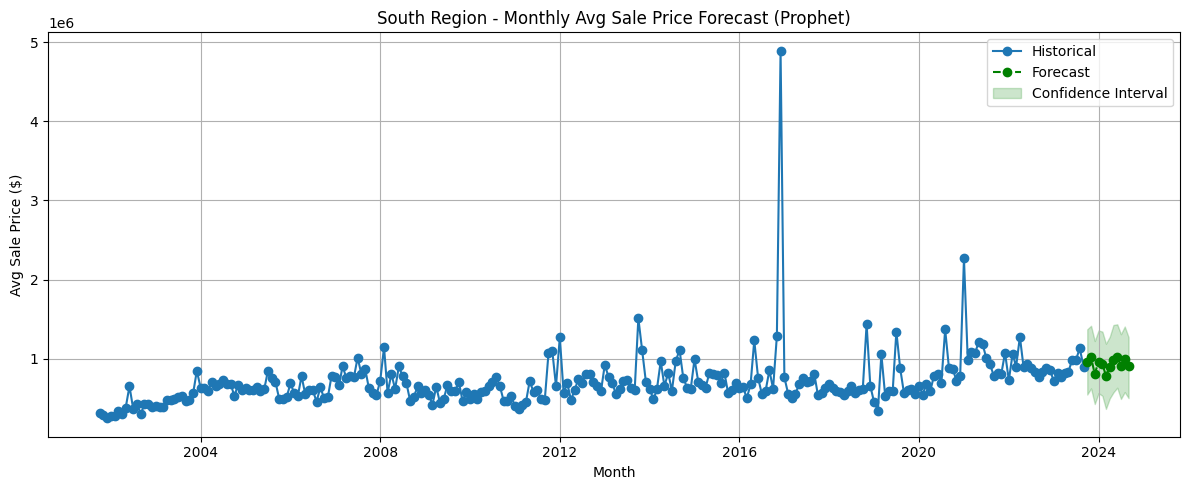


 Forecasting Monthly Avg Sale Price for Region: East


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/z___ezeg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/165cmf4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64096', 'data', 'file=/tmp/tmpv8d69tex/z___ezeg.json', 'init=/tmp/tmpv8d69tex/165cmf4e.json', 'output', 'file=/tmp/tmpv8d69tex/prophet_modely_qxv9k7/prophet_model-20250429014500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Saved: forecast_monthly_prophet_East.csv


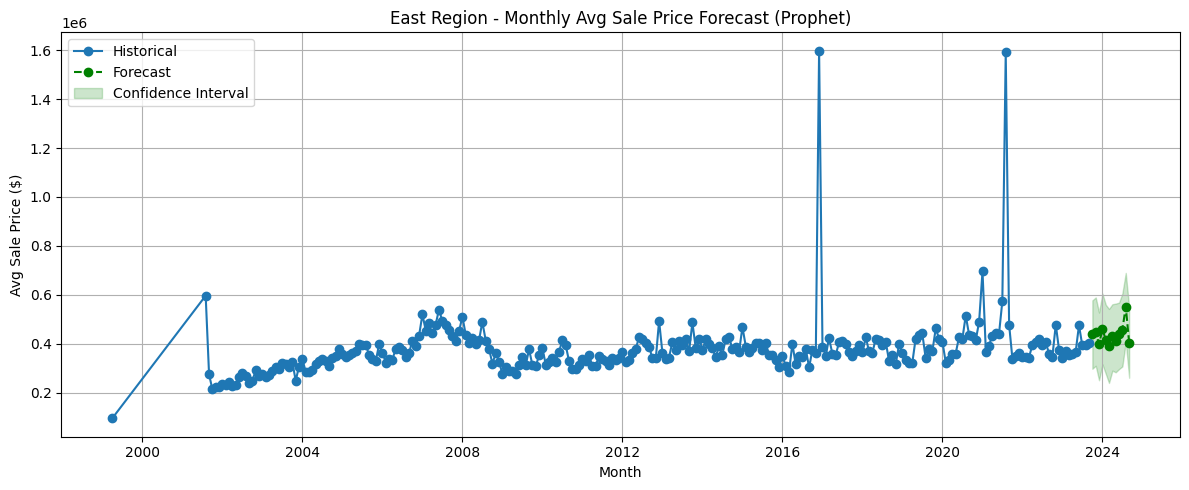


 Forecasting Monthly Avg Sale Price for Region: West


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/4t4o9ea5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8d69tex/bn912vq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94040', 'data', 'file=/tmp/tmpv8d69tex/4t4o9ea5.json', 'init=/tmp/tmpv8d69tex/bn912vq5.json', 'output', 'file=/tmp/tmpv8d69tex/prophet_model9rkcxty8/prophet_model-20250429014510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Saved: forecast_monthly_prophet_West.csv


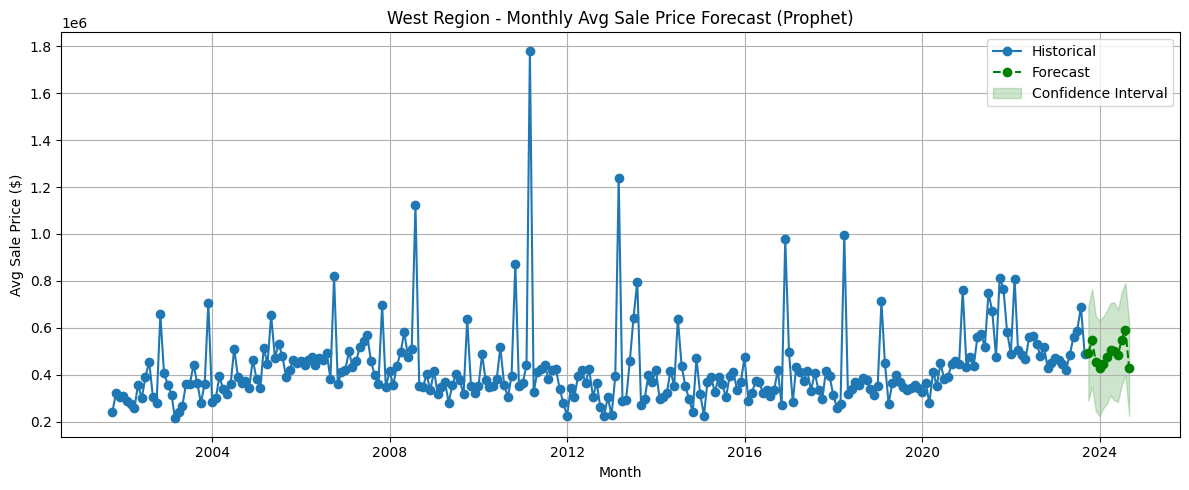

In [43]:
from pyspark.sql.functions import regexp_extract, col, to_date, year, month, avg, when, date_format
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# STEP 1: Extract Lat/Lon from 'Location'
df = df.withColumn("Longitude", regexp_extract("Location", r"POINT \((-?\d+\.\d+)", 1).cast("double"))
df = df.withColumn("Latitude", regexp_extract("Location", r"(-?\d+\.\d+)\)$", 1).cast("double"))

# STEP 2: Assign Region
df = df.withColumn("Region",
    when(col("Latitude") > 41.7, "North")
    .when(col("Latitude") < 41.3, "South")
    .when(col("Longitude") < -73.3, "West")
    .otherwise("East")
)

# STEP 3: Parse date and extract month-year
df = df.withColumn("parsed_date", to_date("Date Recorded", "M/d/yyyy"))
df = df.withColumn("month", date_format("parsed_date", "yyyy-MM-01"))  # normalize to 1st of month

# STEP 4: Group by Region + Month
df_monthly_region = df.groupBy("Region", "month").agg(avg("Sale Amount").alias("avg_sale"))
regions = ["North", "South", "East", "West"]

# STEP 5: Forecasting using Prophet
for region in regions:
    print(f"\n Forecasting Monthly Avg Sale Price for Region: {region}")

    pdf = df_monthly_region.filter(col("Region") == region).toPandas()

    if pdf.empty or len(pdf) < 24:
        print(f" Not enough monthly data for {region}, skipping.")
        continue

    # Prepare data
    pdf = pdf.sort_values("month").dropna()
    pdf = pdf.rename(columns={"month": "ds", "avg_sale": "y"})
    pdf["ds"] = pd.to_datetime(pdf["ds"])
    pdf = pdf[pdf["y"] > 0]

    # Fit Prophet model with monthly seasonality
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(pdf)

    # Forecast next 12 months
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)


    result = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(12)
    result["Region"] = region
    result.columns = ["Month", "Predicted Avg Sale Price", "Lower Bound", "Upper Bound", "Region"]


    result.to_csv(f"forecast_monthly_prophet_{region}.csv", index=False)
    print(f" Saved: forecast_monthly_prophet_{region}.csv")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(pdf["ds"], pdf["y"], label="Historical", marker='o')
    plt.plot(result["Month"], result["Predicted Avg Sale Price"], color="green", linestyle='--', marker='o', label="Forecast")
    plt.fill_between(result["Month"], result["Lower Bound"], result["Upper Bound"], color="green", alpha=0.2, label="Confidence Interval")
    plt.title(f"{region} Region - Monthly Avg Sale Price Forecast (Prophet)")
    plt.xlabel("Month")
    plt.ylabel("Avg Sale Price ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [45]:
import pandas as pd
import glob

# Step 1: Load forecast CSVs for each region
forecast_files = glob.glob("forecast_monthly_prophet_*.csv")

# Step 2: Read each file into a dictionary by region
forecast_dfs = {}
for file in forecast_files:
    region_name = file.split("_")[-1].replace(".csv", "")
    df = pd.read_csv(file)
    df["Month"] = pd.to_datetime(df["Month"]).dt.strftime("%Y-%m")  # Format month
    forecast_dfs[region_name] = df

# Step 3: Display each region's forecast table
for region, df in forecast_dfs.items():
    print(f"\n Forecast Table - {region} Region")
    print(df.to_string(index=False))



 Forecast Table - North Region
  Month  Predicted Avg Sale Price   Lower Bound   Upper Bound Region
2023-10             366672.354473 256205.299673 482638.820682  North
2023-11             377396.876989 257700.604873 484594.674935  North
2023-12             431234.361372 322179.891013 547116.641829  North
2024-01             400713.074538 293981.950415 512864.878684  North
2024-02             383389.079207 264986.356901 493981.860539  North
2024-03             379018.378954 279147.164146 488520.209604  North
2024-04             378725.501230 269841.749632 489914.887759  North
2024-05             383545.075215 265648.517296 494744.415174  North
2024-06             420192.207375 319666.968442 528314.820160  North
2024-07             452430.061938 345732.797233 565704.497027  North
2024-08             423902.328055 312241.439341 542503.264306  North
2024-09             394371.847610 281615.419820 500169.013679  North

 Forecast Table - West Region
  Month  Predicted Avg Sale Price   Lowe

- This model extracts latitude and longitude from Location, assigns a Region (North, South, East, West) based on coordinates, groups sales monthly by region, builds Prophet models for each region separately, and plots forecasts

- ## Final Conclusion

Using Prophet, we successfully modeled and forecasted the regional trends in monthly real estate sales. By first segmenting the data into North, South, East, and West regions based on latitude and longitude, we could capture distinct seasonal and growth patterns across different areas. The Prophet models highlighted how regional dynamics influence sales behavior over time, providing valuable insights for more localized forecasting. This approach demonstrates the importance of considering geographic factors when analyzing and predicting market trends.
